In [2]:
from environment.connect4 import Connect4
import copy
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
n_episodes = 100000
a=0.5
for episode in range(n_episodes):
    if episode % (n_episodes//5) == 0:
        a-=0.1
        print(a)
        print(f"Episode {episode}/{n_episodes}")

0.4
Episode 0/100000
0.30000000000000004
Episode 20000/100000
0.20000000000000004
Episode 40000/100000
0.10000000000000003
Episode 60000/100000
2.7755575615628914e-17
Episode 80000/100000


In [1]:
import argparse
import tqdm
from environment.connect4 import Connect4
from agents.deep_Q import Deep_Q_agent
from agents.Q_learning import QLearningAgent
from agents.human_agent import HumanAgent
from agents.random_agent import RandomAgent
from environment.graphics import display_game


def train_agents(agent1, agent2, n_episodes):
    n_s1=[0]


    # Boucle principale
    for episode in tqdm.tqdm(range(n_episodes)):
        game = Connect4()
        state = game.board
        done = False
        
        while not done:
            # Joueur 1 choisit une action
            action1 = agent1.choose_action(state)
            # Mise à jour de l'état
            next_state, reward, done = game.push(action1, color=0)
            # Mise à jour de la table Q du joueur 1
            agent1.update_q_table(state, action1, reward, next_state)

            state = next_state
            if done:
                break

            # Joueur 2 choisit une action
            action2 = agent2.choose_action(state)
            # Mise à jour de l'état
            next_state, reward, done = game.push(action2, color=1)
            # Mise à jour de la table Q du joueur 2
            agent2.update_q_table(state, action2, reward, next_state)

            state = next_state
        n_s1.append(agent1.state_max)
    return agent1, agent2,n_s1

print("Training q-learning agents...")
ag1,ag2,ag3 = QLearningAgent(name='Q_learning1'), QLearningAgent(name='Q_learning2'), QLearningAgent(name='Q_learning3')
_, _,n_s1 = train_agents(ag1, RandomAgent(), 50000)
_, _,n_s1p = train_agents(ag2, ag3, 50000)
print("Training done !")

c:\Users\wangf\Documents\CS_3A\RL\Connect4\connect4\agents\deep_Q.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  example_tensor = torch.tensor([example_state],dtype=torch.float)


Training q-learning agents...


100%|██████████| 50000/50000 [02:38<00:00, 314.90it/s]

Training done !


In [2]:
ag1=0
ag2=0
ag3=0

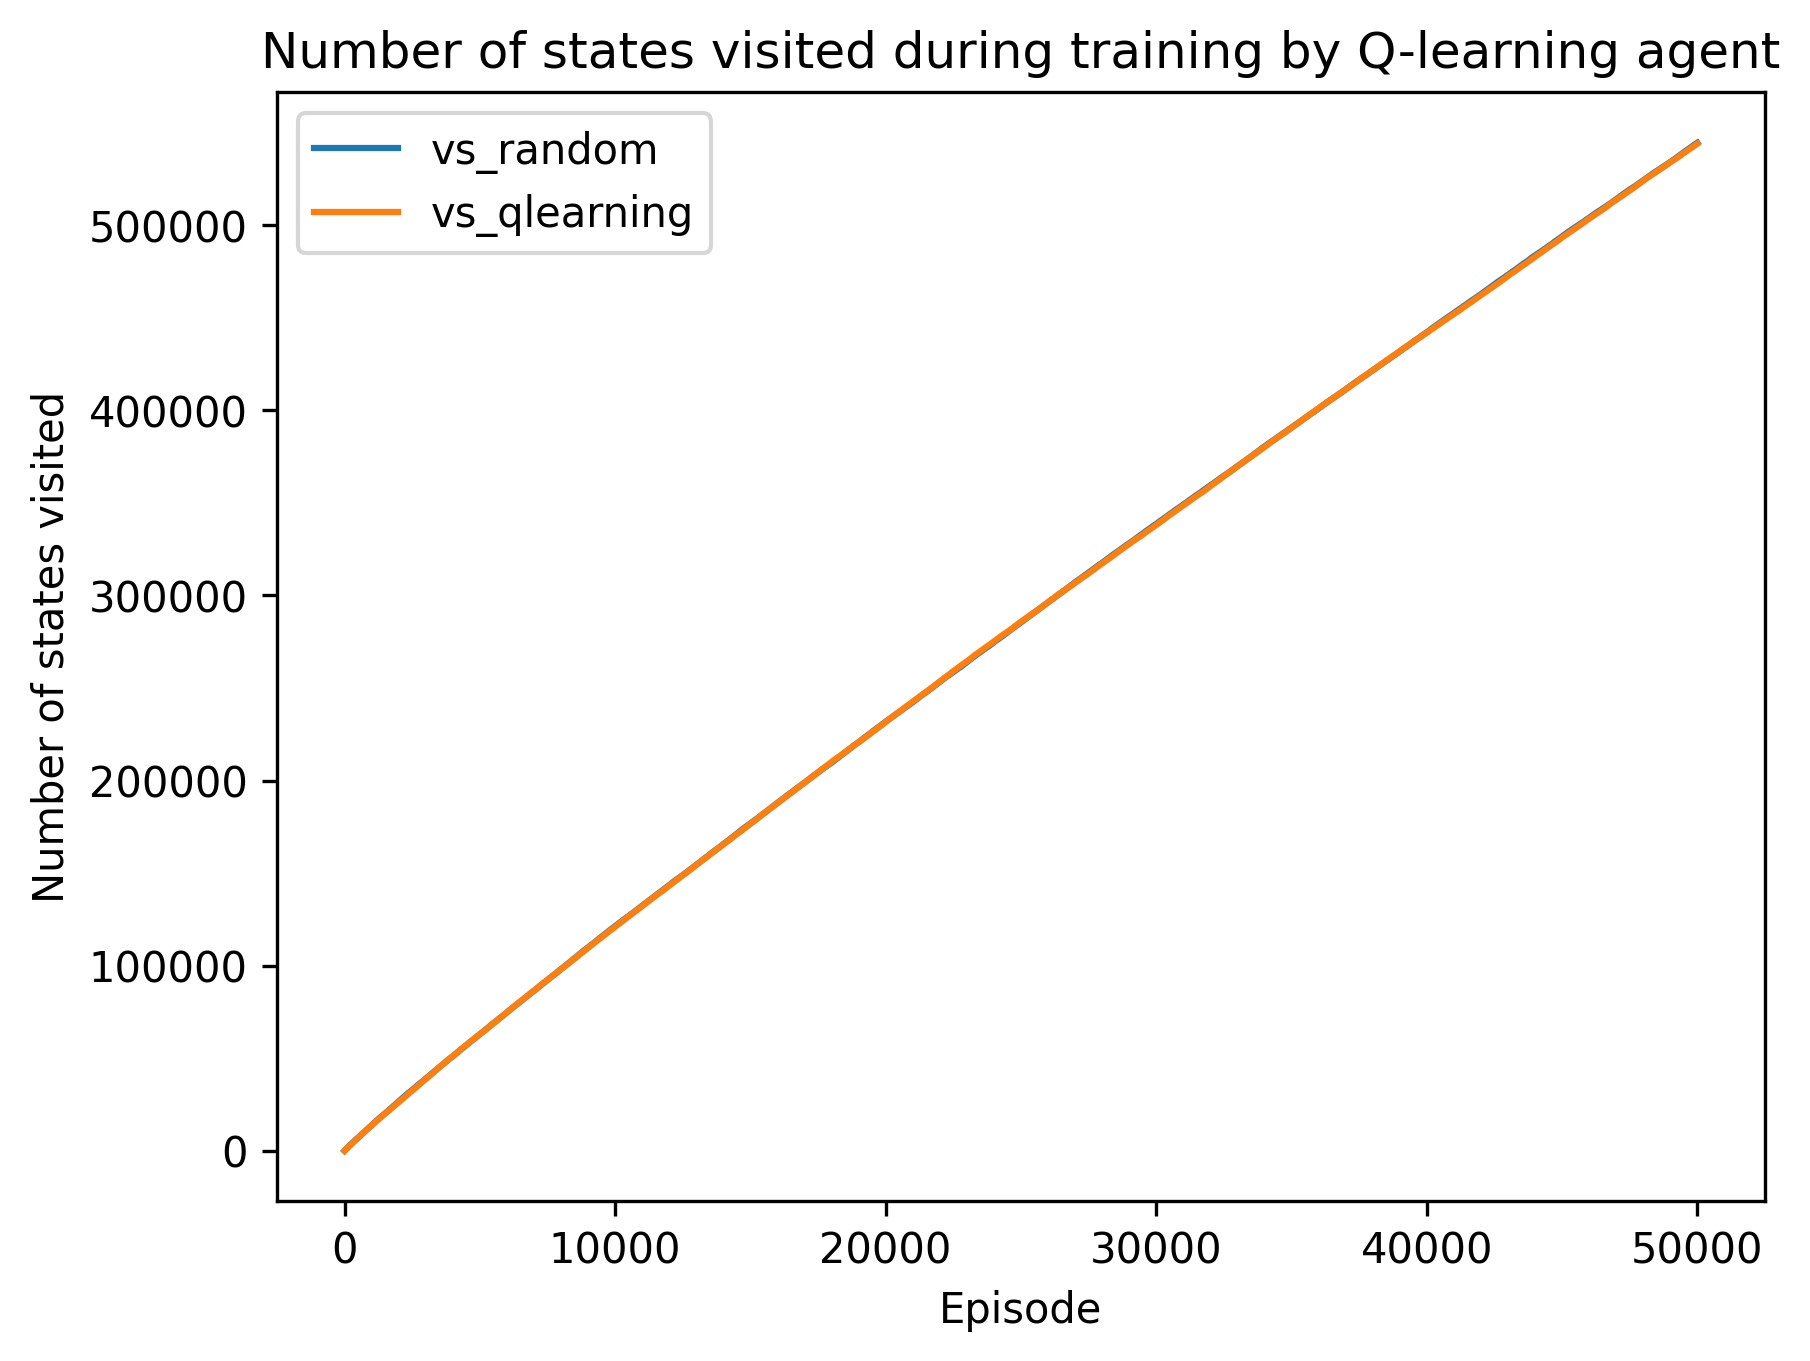

In [8]:
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.plot(n_s1,label='vs_random')
plt.plot(n_s1p,label='vs_qlearning')
plt.legend()
plt.xlabel('Episode')

plt.ylabel('Number of states visited')
plt.title('Number of states visited during training by Q-learning agent')
plt.show()

In [5]:
n_s1[-1],n_s1p[-1]

(544539, 544001)

In [3]:
game=Connect4()
state,_,_=game.push(0)

In [2]:
def show_game(board):
    print("   " + "   ".join(str(i) for i in range(7)))
    print(" +" + "---+" * 7)
    for row in reversed(range(6)):
        print(f"{row}|", end="")
        for col in range(7):
            to_print=" "
            if board[col,row]==1:
                to_print="X"
            elif board[col,row]==-1:
                to_print="O"
            print(f" {to_print} |", end="")
        print("\n +" + "---+" * 7)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class ConvNet(nn.Module):
    

    def __init__(self, optimizer=optim.Adam, criterion=nn.MSELoss(),lr=10**-3,disc_f=0.5):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 , 64)
        self.fc2 = nn.Linear(64, 7)
        #self._initialize_weights()
        self.optimizer = optimizer(self.parameters(),lr)
        self.criterion = criterion
        self.discount_factor = disc_f
        self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, x):
        x = x.view(-1, 1, 7, 6)  # Reshape input to (batch_size, channels, height, width)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # def forward(self, x):
    #     x = x.transpose(1,3)
    #     x = x.transpose(2,3)
    #     x = self.relu1(self.conv1(x))
    #     x = self.pool1(x)
    #     x = self.relu2(self.conv2(x))
    #     x = self.flatten(x)
    #     x = self.relu3(self.fc1(x))
    #     output = self.output(x)
    #     return output

    def train_model(self, train_loader, epochs=3,show=False):
        for p in self.parameters():
            p.requires_grad = True
        self.train()
        running_loss = 0.0

        for epoch in range(epochs):
            
            for _, batch_data in enumerate(train_loader):

                states, actions, rewards, next_states, dones = batch_data
                states = states.to(self.device).float()
                actions = actions.to(self.device)
                rewards = rewards.to(self.device).float()
                next_states = next_states.to(self.device).float()
                targets = rewards.clone()

                with torch.no_grad():
                    next_state_values = self(next_states).max(1)[0].detach()
                    targets[~dones] -= self.discount_factor * next_state_values[~dones]
                outputs = self(states)
                targets_f = copy.deepcopy(outputs.detach())
                targets_f[range(len(targets_f)), actions] = targets
                self.optimizer.zero_grad()

                loss = self.criterion(outputs, targets_f)
                #loss = F.smooth_l1_loss(outputs, targets_f)
                loss.backward()
                running_loss += loss.item()
                self.optimizer.step()

            if show :
                if epoch ==0:
                    print(f"Loss: {running_loss}")
                    running_loss = 0.0
        self.eval()

In [5]:
class Deep_Q_agent:

    def __init__(self, learning_rate=10**-1, discount_factor=0.9, exploration_rate=0.5,n_player=0):
        self.n_player = n_player
        self.action_size = 7
        self.state_size = 7*6
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_table = np.zeros((7,6))
        self.model = ConvNet(optim.Adam, nn.MSELoss(),lr=learning_rate,disc_f=discount_factor)
        self.model.to(self.model.device)
        self.model.eval()
        self.memory = []

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def clear_memory(self):
        self.memory = []

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            return np.random.choice(self.action_size)
        else:
            if self.n_player==0:
                return np.argmax(self.model(torch.from_numpy(state).float().unsqueeze(0).to(device)).detach().cpu().numpy()[0])
            else:
                return np.argmax(self.model(torch.from_numpy(-state).float().unsqueeze(0).to(device)).detach().cpu().numpy()[0])

    def update_q_table(self,show=False):
        dataset = CustomDataset(self.memory)
        train_loader = DataLoader(dataset, batch_size=32, shuffle=False)
        self.model.train_model(train_loader,show=show)
        self.clear_memory()

In [6]:
def train_agents(agent,it,rndm=False):
    count_illegal=[]
    c_i=0
    for episode in tqdm(range(1,it)):
        game=Connect4()
        state = copy.deepcopy(game.board)
        done = False
        while not done:

            if rndm and episode%2 ==1:

                action = np.random.randint(0,7)
                next_state, reward, done = game.push(action, color=1)
                state = next_state
                
            else:

                action = agent.choose_action(state)
                next_state, reward, done = game.push(action, color=1)
                if reward == -20:
                    c_i+=1
                opp_next_state = -copy.deepcopy(next_state)
                agent.memorize(copy.deepcopy(state), action, reward, opp_next_state, done)
                state = next_state

            if not done :
                if rndm and episode%2 ==0 :

                    action = np.random.randint(0,7)
                    next_state, reward, done = game.push(action, color=-1)
                    state = next_state

                else:

                    opp_state = -copy.deepcopy(state)
                    action = agent.choose_action(opp_state)
                    next_state, reward, done = game.push(action, color=-1)
                    if reward == -20:
                        c_i+=1
                    agent.memorize(opp_state, action, reward, copy.deepcopy(next_state), done)
                    state = next_state

        if episode % 2 == 0:
            if episode %100 == 0:
                show=False
                count_illegal.append(c_i/100)
                c_i=0
            else:
                show=False
            agent.update_q_table(show=show)
    return count_illegal

In [7]:
count_illegal=[]  
train=True
if train:
    agent = Deep_Q_agent()
    for p in range(5):
        print(p)
        agent.exploration_rate=0.4-p/10
        count_illegal.extend(train_agents(agent,it=1000))
        count_illegal.extend(train_agents(agent,it=2000,rndm=True))
        
    
    agent2=copy.deepcopy(agent)
    agent2.n_player=1

0


100%|██████████| 1999/1999 [00:48<00:00, 41.45it/s]


1


100%|██████████| 1999/1999 [00:49<00:00, 40.00it/s]


2


100%|██████████| 1999/1999 [00:49<00:00, 40.54it/s]


3


100%|██████████| 1999/1999 [00:43<00:00, 45.75it/s]


4


100%|██████████| 1999/1999 [00:54<00:00, 36.61it/s]


In [8]:
game=Connect4()
game.play_a_game(agent,agent2)

   0   1   2   3   4   5   6
 +---+---+---+---+---+---+---+
5|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
4|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
3|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
2|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
1|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
0|   |   |   |   |   | X |   |
 +---+---+---+---+---+---+---+
   0   1   2   3   4   5   6
 +---+---+---+---+---+---+---+
5|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
4|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
3|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
2|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
1|   |   |   |   |   | O |   |
 +---+---+---+---+---+---+---+
0|   |   |   |   |   | X |   |
 +---+---+---+---+---+---+---+
   0   1   2   3   4   5   6
 +---+---+---+---+---+---+---+
5|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
4|   |   |   |

1

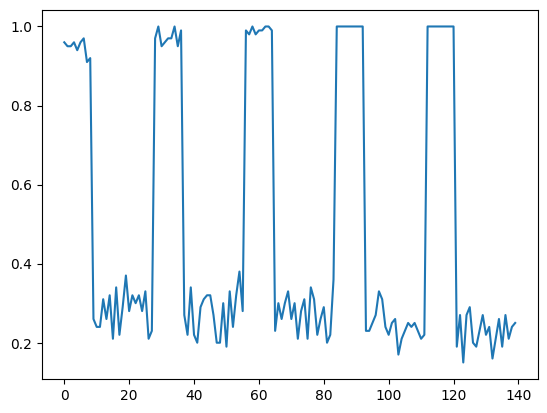

In [9]:
import matplotlib.pyplot as plt
plt.plot(count_illegal)

In [10]:
for i in range(len(agent.memory)):
    print(agent.model(torch.tensor(np.array([agent.memory[i][0]])).float()))
    show_game(agent.memory[i][0])

tensor([[-1.9224, -2.2009, -1.8631, -2.4948, -2.8880, -0.5389, -2.0446]],
       grad_fn=<AddmmBackward0>)
   0   1   2   3   4   5   6
 +---+---+---+---+---+---+---+
5|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
4|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
3|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
2|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
1|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
0| O |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
tensor([[-1.9224, -2.2009, -1.8631, -2.4948, -2.8880, -0.5389, -2.0446]],
       grad_fn=<AddmmBackward0>)
   0   1   2   3   4   5   6
 +---+---+---+---+---+---+---+
5|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
4|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
3|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
2|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
1|   |   |   |   |   |   |   |
 +---+---+---+-

In [ ]:
game=Connect4()
s = game.board
agent_test = Deep_Q_agent()
agent_test.exploration_rate=0
#print(agent.model(torch.tensor([s]).float()))
print(agent_test.model(torch.tensor(np.array([s])).float()))

tensor([[0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward0>)


In [29]:
for i in range(len(agent_test.memory)):
    print(agent_test.model(torch.tensor([agent_test.memory[i][0]]).float()))
    print(agent_test.memory[i][1])
    print(agent_test.memory[i][2])

In [30]:
show_game(agent_test.memory[i][0])

NameError: name 'i' is not defined

In [31]:
for i in range(len(agent_test.memory)):
    print(agent_test.model(torch.tensor([agent_test.memory[i][0]]).float()))

In [255]:
if (agent_test.model(states)==agent_test.model(states)[0]).all():
    print(1)

1


In [173]:
actions

tensor([4, 4, 4, 4, 4, 4, 4], dtype=torch.int32)

In [174]:
next_state_values

tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006])

In [175]:
targets

tensor([-5.2301e-04, -5.2301e-04, -5.2301e-04, -5.2301e-04, -5.2301e-04,
        -5.2301e-04, -2.0000e+00])

In [269]:
targets_f

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-2.,  0.,  0.,  0.,  0.,  0.,  0.]], grad_fn=<IndexPutBackward0>)

In [177]:
outputs

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0006, -0.0009,  0.0000]],
       grad_fn=<AddmmBackward0>)

In [178]:
agent_test.model(states)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0003, -0.0014,  0.0000]],
       grad_fn=<AddmmBackward0>)

In [179]:
loss

tensor(0.0306, grad_fn=<SmoothL1LossBackward0>)

In [ ]:
agent.update_q_table()

In [ ]:
game=Connect4()
game.play_a_game(agent1="human",agent2 = agent2)

In [51]:
game=Connect4()
s = game.board
game.show()

   0   1   2   3   4   5   6
 +---+---+---+---+---+---+---+
5|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
4|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
3|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
2|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
1|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+
0|   |   |   |   |   |   |   |
 +---+---+---+---+---+---+---+


In [52]:
agent = Deep_Q_agent()

In [46]:
agent.model(torch.tensor([s]).float())

tensor([[1., 1., 1., 1., 1., 1., 1.]], grad_fn=<AddmmBackward0>)